In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from load_djembe_marker import *
from foot_module import onset_calculations, onset_extraction, onset_filtering, utils, onset_plot
from compute_tempo import *
from pydub import AudioSegment
from pydub.generators import Triangle
from scipy.signal import savgol_filter, argrelmax, find_peaks
from scipy.signal import butter, filtfilt


In [2]:
OnsetProcessor = onset_calculations.OnsetProcessor()

mvnx_filepath = os.listdir("/itf-fi-ml/home/sagardu/djembe_drive/Data/DD_MultiM_Proc/MoCap_proc/MVNX")
dance_annotations = os.listdir("/itf-fi-ml/home/sagardu/djembe_drive/sgr_pyspace/subset_dance_annotation")
mnvx_files = []
cycle_file = []

for filename in dance_annotations:

    filen = filename.split("_Dancers")[0]
    mnvx_files.append(filen+"_T.mvnx")
    cycle_file.append(filen+"_C.csv")

Loaded: BKO_E3_D5_03_Wasulunka_Dancers.csv
Loaded: BKO_E3_D5_03_Wasulunka_C.csv
Loaded BKO_E3_D5_03_Wasulunka_T pickle


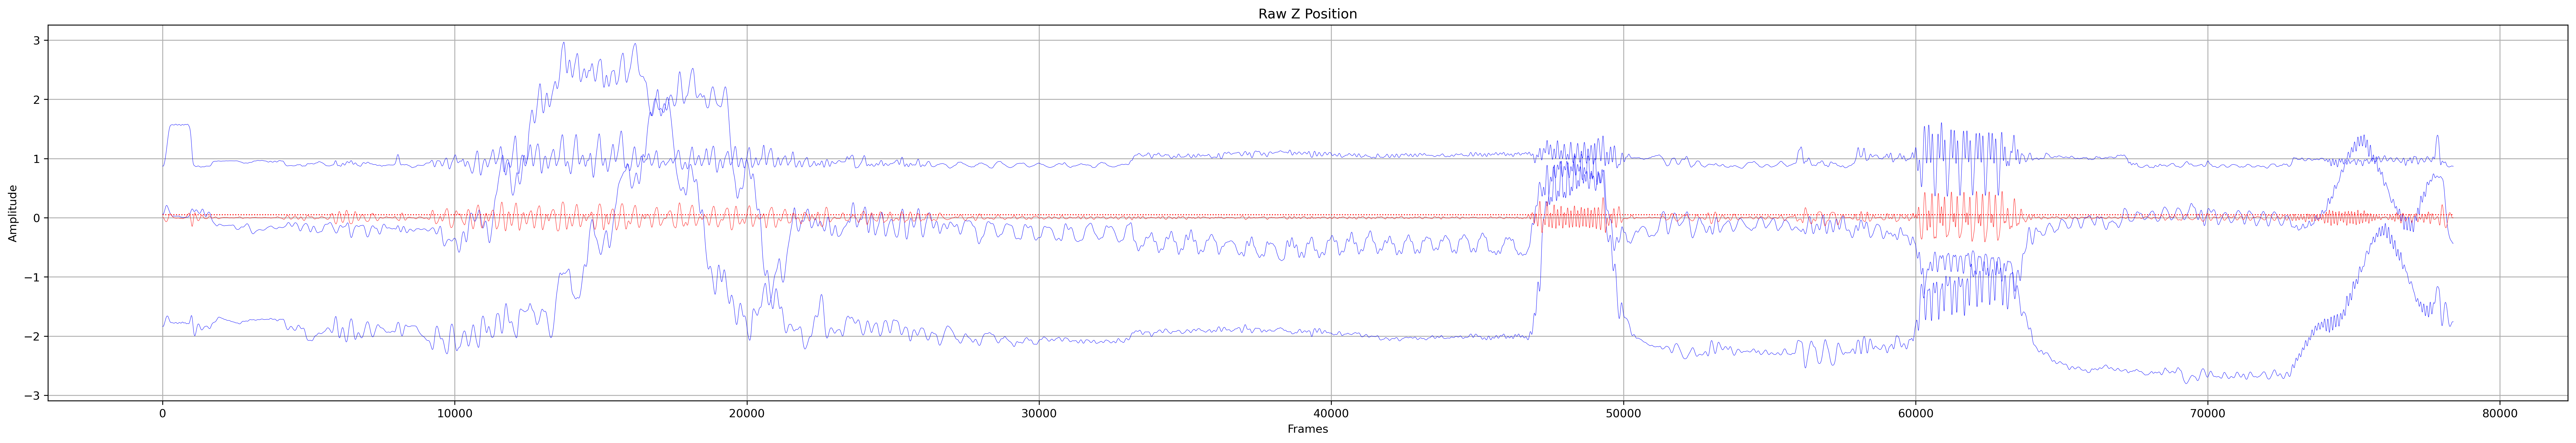

In [ ]:
k = 1
file_path = f"/itf-fi-ml/home/sagardu/djembe_drive/Data/DD_MultiM_Proc/MoCap_proc/MVNX/{mnvx_files[k]}"
file_name = os.path.basename(file_path).split(".")[0]
piece_name = file_name.split("_")[4]
ensemble_name = file_name.split("_")[1]
day = file_name.split("_")[2]

# Load dance annotations
df_annotation = pd.read_csv(f"/itf-fi-ml/home/sagardu/djembe_drive/sgr_pyspace/subset_dance_annotation/{dance_annotations[k]}")
print("Loaded:", dance_annotations[k])

# Load meter cycle onsets
df_metric = pd.read_csv(f"/itf-fi-ml/home/sagardu/djembe_drive/sgr_pyspace/metric_cycles/{cycle_file[k]}")
loaded_mcycle_onsets = np.round(df_metric["Selected Onset"].to_numpy(), 3)
print("Loaded:", cycle_file[k])
# print("\n")

pickle_path = f'./output/motion_data_pkl/{file_name}.pkl'

if os.path.isfile(pickle_path):
    with open(pickle_path, 'rb') as file:
        motion_data = pickle.load(file)
    print(f"Loaded {file_name} pickle")


# directory creation
base_logs_folder = "logs"
piece_folder_name = file_name.split(".")[0]
piece_folder_path = utils.create_folder(base_logs_folder, piece_folder_name)

sensorA_segname = 'SEGMENT_RIGHT_HAND'          # # SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8   SEGMENT_RIGHT_SHOULDER
segment_name = "Pelvis"


sensorA_pos = motion_data['position'][sensorA_segname]     # size (n, 3)
sensorA_pos_smooth = smooth_velocity(sensorA_pos, abs='no')             # size (n, 3)
# xyz_pos= np.sqrt(sensorA_pos_smooth[:,0]**2 + sensorA_pos_smooth[:,1]**2 + sensorA_pos_smooth[:,2]**2).flatten()

detrended_pos = detrend_signal_array(sensorA_pos_smooth, cutoff= 0.5)    # sensorA_pos_smooth[:,1]


plt.figure(figsize=(40, 6), dpi=300)
plt.plot(detrended_pos, linewidth=0.3, color = 'red')

plt.hlines(y=np.array([0.05]), xmin=0.0, xmax=len(detrended_pos), color='r', linestyle='dotted', linewidth=0.9)
# plt.plot(filtered_peaks,abs_filtered_data[filtered_peaks], "x")
plt.xlabel('Frames')
plt.ylabel('Amplitude')
plt.title('Raw Z Position')
plt.grid(True)
plt.show()

In [ ]:
def position_based_novelty(position_array, order=15, pos_threshold=0.05):
    
    # pisition_array is the detrended position data (n,3)
    
    dir_change_onset_arr = np.array([])
    onset_data_list = []
    for i in range(position_array.shape[1]):
        abs_detrended_pos = abs(position_array[:,i]) 
        maxima_indices = argrelmax(abs_detrended_pos, order=order)[0]
                                                      # Remove peaks with values below the position threshold
        filtered_maxima_frm = maxima_indices[abs_detrended_pos[maxima_indices] >= pos_threshold]
        binary_onset_data = np.zeros(len(position_array[:,i]))
        binary_onset_data[filtered_maxima_frm] = 1      # directional change onsets represented by value 1

        onset_data_list.append(binary_onset_data)
    dir_change_onset_arr = np.column_stack(onset_data_list)
    
    return dir_change_onset_arr


pos_onsets = position_based_novelty(detrended_pos, pos_threshold=0.09)
# pos_fil = filter_dir_onsets_by_threshold(pos_onsets, threshold_s=0.25)

pos_fil_onsets_b = np.sum(pos_onsets, axis=1)
pos_fil_onsets_b = np.where(pos_fil_onsets_b > 0, 1,0)
pos_fil_onsets_bfil = filter_dir_onsets_by_threshold(pos_fil_onsets_b.reshape(-1,1), threshold_s=0.25)
pos_fil_onsets_f = pos_fil_onsets_bfil.flatten()

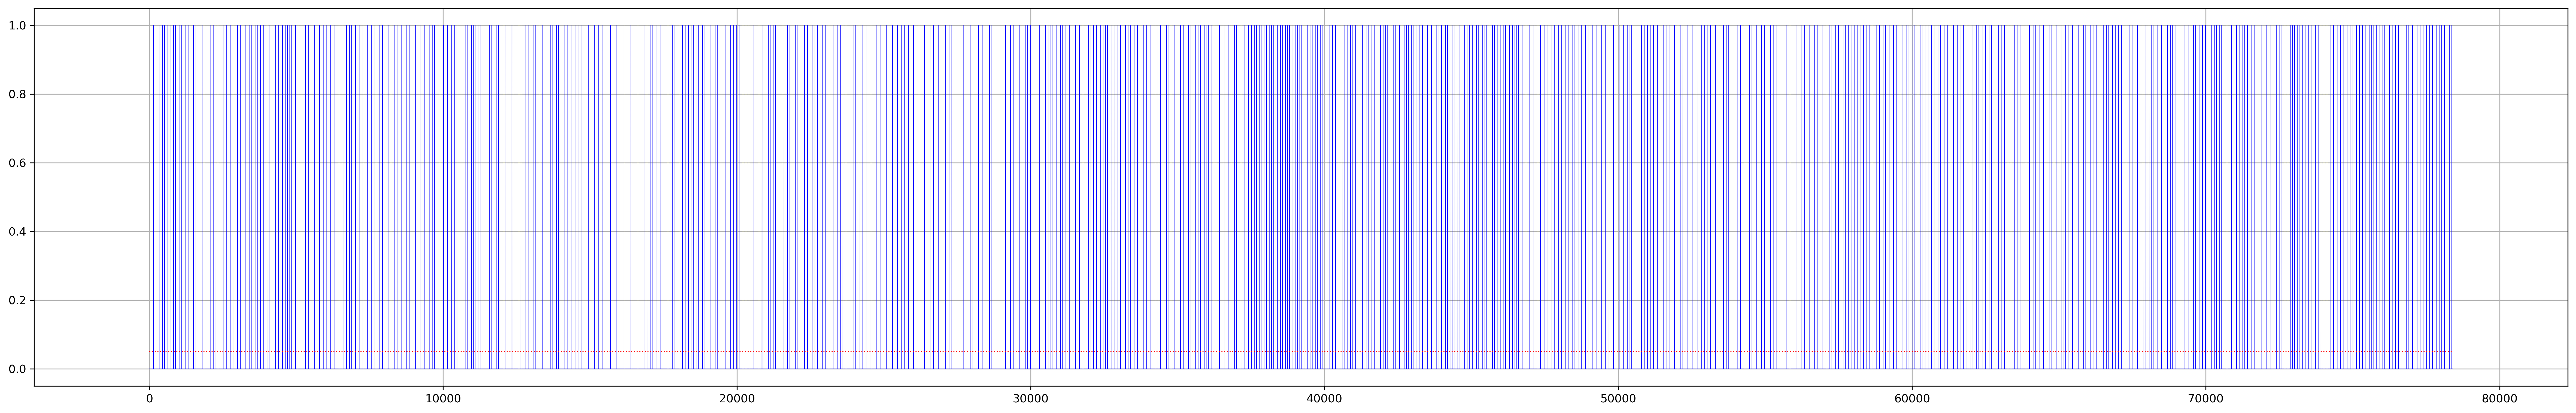

In [ ]:
plt.figure(figsize=(40, 6), dpi=300)
plt.plot(pos_fil_onsets_f, linewidth=0.3, color = 'blue')
# plt.plot(a2, linewidth=0.3, color = 'blue')
plt.hlines(y=np.array([0.05]), xmin=0.0, xmax=len(detrended_pos), color='r', linestyle='dotted', linewidth=0.9)

plt.grid(True)
plt.show()

In [ ]:
kde_gr = []
kde_in = []
kde_au = []
onset_per_piece_info = []

kde_data_per_piece = {
    "Suku": {"gr": [], "in": [], "au": []},     # all suku recordings
    "Wasulunka": {"gr": [], "in": [], "au": []},
    "Maraka": {"gr": [], "in": [], "au": []},
    "Dansa": {"gr": [], "in": [], "au": []},
    "Sandia": {"gr": [], "in": [], "au": []},
    "Manjanin": {"gr": [], "in": [], "au": []}
}

kde_data_per_dancer = {
    "dancer_1": {"gr": [], "in": [], "au": []},
    "dancer_2": {"gr": [], "in": [], "au": []},
    "dancer_3": {"gr": [], "in": [], "au": []},
    "dancer_4": {"gr": [], "in": [], "au": []},
}

kde_data_all_pieces = {"gr": [], "in": [], "au": []}

for k in tqdm(range(len(dance_annotations))):
    
    file_path = f"/itf-fi-ml/home/sagardu/djembe_drive/Data/DD_MultiM_Proc/MoCap_proc/MVNX/{mnvx_files[k]}"
    file_name = os.path.basename(file_path).split(".")[0]
    piece_name = file_name.split("_")[4]
    ensemble_name = file_name.split("_")[1]
    day = file_name.split("_")[2]
    
    # Load dance annotations
    df_annotation = pd.read_csv(f"/itf-fi-ml/home/sagardu/djembe_drive/sgr_pyspace/subset_dance_annotation/{dance_annotations[k]}")
    print("Loaded:", dance_annotations[k])
    
    # Load meter cycle onsets
    df_metric = pd.read_csv(f"/itf-fi-ml/home/sagardu/djembe_drive/sgr_pyspace/metric_cycles/{cycle_file[k]}")
    loaded_mcycle_onsets = np.round(df_metric["Selected Onset"].to_numpy(), 3)
    print("Loaded:", cycle_file[k])
    # print("\n")
    
    pickle_path = f'./output/motion_data_pkl/{file_name}.pkl'
    
    if os.path.isfile(pickle_path):
        with open(pickle_path, 'rb') as file:
            motion_data = pickle.load(file)
        print(f"Loaded {file_name} pickle")
    
    
    # directory creation
    base_logs_folder = "logs"
    piece_folder_name = file_name.split(".")[0]
    piece_folder_path = utils.create_folder(base_logs_folder, piece_folder_name)

    sensorA_segname = 'SEGMENT_PELVIS'          # SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8
    segment_name = "Pelvis_Zpos"
    axis = 2        # x:0 y:1 z:2
    mocap_fps = 240
    
    sensorA_velocity = motion_data['position'][sensorA_segname] # size (n, 3)
    sensorA_abs_vel = smooth_velocity(sensorA_velocity, abs='no') # size (n, 3)
    
    # sensorA_onsets_frm = argrelmax(sensorA_velocity[:,axis], order=15)[0]
    # sensorA_onsets_t = sensorA_onsets_frm/mocap_fps
    
    # Remove drift by cutting off low frequency components
    cutoff = 0.8  # Cutoff frequency in Hz
    b, a = butter(2, cutoff / (mocap_fps / 2), btype='highpass')

    detrended_data = filtfilt(b, a, sensorA_velocity[:,axis])        # Detrended position data
    abs_detrended_data = abs(detrended_data)                          # Abs of the position data

    pospeaks = argrelmax(abs_detrended_data, order=15)[0]

    threshold = 0.02                                                # Remove peaks with values below the position threshold
    sensorA_onsets_frm = pospeaks[abs_detrended_data[pospeaks] >= threshold]
    sensorA_onsets_t = sensorA_onsets_frm/mocap_fps
    
    
    # xyz= np.sqrt(sensorA_abs_vel[:,0]**2 + sensorA_abs_vel[:,1]**2 + sensorA_abs_vel[:,2]**2).flatten()
    # sensorA_onsets_frm = argrelmax(xyz, order=15)[0]
    # sensorA_onsets_t = sensorA_onsets_frm/mocap_fps
    ###################################################
    ################### SAVE INFO #####################
    
    onsetinfo_folder_name = "onset_info"
    onsetinfo_folder_path = utils.create_folder(base_logs_folder, piece_folder_name, onsetinfo_folder_name)

    df_sensor_onset = pd.DataFrame({"time_sec": sensorA_onsets_t, "frames": sensorA_onsets_frm})
    df_sensor_onset.to_csv(os.path.join(onsetinfo_folder_path, f"{file_name}_{segment_name}_onsets.csv"), index=False)

    
    #########################################################
    #########################################################
    ############ Kernel Density Estimation Part #############
    
    kde_folder_name = "average_kde_plots"
    kde_folder_path = utils.create_folder(base_logs_folder, piece_folder_name, kde_folder_name)
    
    
    modes = df_annotation["mocap"].unique().tolist()
    print("Mode processing initiated...")
    
    kde_list = []   # collect feet_onsets for the 3 modes for subplot
    for mocap_mode in modes:

        category_df = df_annotation.groupby('mocap')
        category_df = category_df.get_group(mocap_mode)
        category_df = category_df.reset_index(drop=True)

        choose_nb_onset_to_make_block = 2
        section_data = OnsetProcessor.onset_calculations(category_df, loaded_mcycle_onsets, choose_nb_onset_to_make_block)

        # directoru creation
        mode_folder_path = utils.create_folder(base_logs_folder, piece_folder_name, mocap_mode)
        
        utils_func = utils.Utils_func(section_data, file_name, segment_name, mocap_mode, mode_folder_path, kde_folder_path)
        feet_onsets = utils_func.collect_foot_onsets_per_cycle(sensorA_onsets_t)
        
        kde = utils_func.kde_plot_save(feet_onsets)     # average kde
        kde_list.append(kde)    # for subplotting the 3 modes
        
        kde_data_all_pieces[mocap_mode].append(kde)     # kde across all pieces
        kde_data_per_piece[piece_name][mocap_mode].append(kde)  # kde per piece type

        if (ensemble_name == "E1" and day == "D1") or (ensemble_name == "E1" and day == "D5"):
            kde_data_per_dancer["dancer_1"][mocap_mode].append(kde)
        if (ensemble_name == "E1" and day == "D2"):
            kde_data_per_dancer["dancer_2"][mocap_mode].append(kde)
        if (ensemble_name == "E2" and day == "D3") or (ensemble_name == "E2" and day == "D4"):
            kde_data_per_dancer["dancer_3"][mocap_mode].append(kde)
        if (ensemble_name == "E3" and day == "D5") or (ensemble_name == "E3" and day == "D6"):
            kde_data_per_dancer["dancer_4"][mocap_mode].append(kde)


    utils_func.kde_subplot_save(kde_list, modes, kde_folder_path)    # for subplotting the 3 modes kde for each piece
    # utils_func.generate_foot_audio_click(righthand_velocity, both_hand_onsets_t, "", piece_folder_path)
    print("\n\n")

print("Saving final kde plots...")
# save kde averaged across different combinations
kde_piece_dancer_path = utils.create_folder(base_logs_folder, f"{segment_name}_kde_plots_per_piece_and_dancer")
modes_list = ["gr", "in", "au"]

# Create and save KDE plots for each piece
for piece_name, kde_data in kde_data_per_piece.items():
    utils_func.kde_per_piece_dancer_subplot_save(kde_data, piece_name, modes_list, kde_piece_dancer_path)

# Create and save KDE plots for each dancer
for dancer_name, kde_data in kde_data_per_dancer.items():
    utils_func.kde_per_piece_dancer_subplot_save(kde_data, dancer_name, modes_list, kde_piece_dancer_path)

# compute and plot average KDE for all pieces
utils_func.saveplot_all_pieces_kde(kde_data_all_pieces, kde_piece_dancer_path)

# # save
# df_onset_info = pd.DataFrame(onset_per_piece_info, columns=['Filename', 'Number of Onsets'])
# df_onset_info.to_csv(os.path.join(onsetinfo_folder_path,"Onset_info_per_piece.csv"), index=False)